# Vorbereitungen
In den Vorbereitungen werden die nötigen Libraries importiert sowie die Funktionen und Strategien definiert.
## Libraries & Funktionen
### Import der Libraries

In [49]:
import yfinance as yf
import backtrader as bt
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

### Abruf und Vorbereitung der ETF-Daten
Die Funktion **fetch_etf_data** lädt historische Marktdaten eines ETFs mit yfinance basierend auf einem Ticker-Symbol sowie einem Start- und Enddatum herunter. Die Daten werden auf die für Backtrader erforderlichen Spalten reduziert, deren Namen angepasst und mit einer zusätzlichen Spalte openinterest ergänzt. Falls keine Daten gefunden werden, wird ein Fehler ausgelöst.


In [50]:
def fetch_etf_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError(f"Keine Daten für {ticker} im angegebenen Zeitraum gefunden.")
    # Backtrader benötigt spezifische Spaltennamen
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    data.columns = ['open', 'high', 'low', 'close', 'volume']
    data['openinterest'] = 0  # Backtrader benötigt diese Spalte
    return data

### Backtesting
Die Funktion **run_backtest** führt einen Backtest mit der Backtesting-Bibliothek Backtrader durch. Sie bereitet die Marktdaten auf, fügt sie zusammen mit der angegebenen Handelsstrategie in die Backtest-Engine ein und setzt das Startkapital sowie die Handelsgebühren. Anschliessend wird der Backtest ausgeführt, das Start- und Endkapital ausgegeben, und optional die Ergebnisse visualisiert.

In [51]:
def backtest_and_collect(data, strategies, seed_capital, commission):
    earnings = []
    for strategy, strategy_name in strategies:
        data_feed = bt.feeds.PandasData(dataname=data)
        cerebro = bt.Cerebro()
        cerebro.adddata(data_feed)
        cerebro.addstrategy(strategy)
        cerebro.broker.setcash(seed_capital)
        cerebro.broker.setcommission(commission)
        strategies_run = cerebro.run()
        final_value = cerebro.broker.getvalue()

        # Signale sammeln
        strat_instance = strategies_run[0]
        buy_signals = getattr(strat_instance, "buy_signals", 0)
        sell_signals = getattr(strat_instance, "sell_signals", 0)

        earnings.append({
            "Strategy": strategy_name,
            "Earnings": final_value,
            "Seed Capital": seed_capital,
            "Profit": final_value - seed_capital,
            "Profit_Percent": (final_value / seed_capital * 100) - 100,
            "Buy Signals": buy_signals,
            "Sell Signals": sell_signals,
            "Cerebro": cerebro,
        })
    return earnings

### Tabelle mit Matplotlib darstellen
Die Funktion display_table_with_matplotlib visualisiert einen Pandas-DataFrame als Tabelle mit Matplotlib. Sie erstellt eine dynamische Tabelle mit angepasster Schriftgrösse und Spaltenbreite, wobei die Zeilen und der Header farblich hervorgehoben werden, um die Lesbarkeit zu verbessern. Schliesslich wird die Tabelle mit plt.show() gerendert und angezeigt.

In [52]:
def display_table_with_matplotlib(df):
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5))  # Dynamische Höhe basierend auf Zeilenanzahl
    ax.axis('tight')
    ax.axis('off')

    # Tabelle hinzufügen
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

    # Stil anpassen
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))

    # Optional: Farben anpassen
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header-Zeilen
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4CAF50')  # Grüner Header
        elif key[0] % 2 == 0:  # Alternierende Zeilen
            cell.set_facecolor('#f9f9f9')  # Hellgrau
        else:
            cell.set_facecolor('#ffffff')  # Weiss

    plt.show()

## Definition der einzelnen Strategien
Die einzelnen Strategien werden als Klassen definiert, um sie später der Backtrader Funktion übergeben zu können. Die Strategien geben die Berechnung der Buy und Sell-Signale vor und geben so den Erfolg oder Misserfolg auf der jeweiligen ETFs vor.
### Standard Moving Average

In [53]:
class SmaStrategy(bt.Strategy):
    params = (("short_sma", 10), ("long_sma", 50))

    def __init__(self):
        self.short_sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.short_sma)
        self.long_sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.long_sma)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.short_sma > self.long_sma and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.short_sma < self.long_sma and self.position:
            self.sell()
            self.sell_signals += 1

### Linear Weighted Moving Average

In [54]:
class LwmaStrategy(bt.Strategy):
    params = (("short_lwma", 10), ("long_lwma", 50))

    def __init__(self):
        self.short_lwma = bt.indicators.WeightedMovingAverage(self.data.close, period=self.params.short_lwma)
        self.long_lwma = bt.indicators.WeightedMovingAverage(self.data.close, period=self.params.long_lwma)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.short_lwma > self.long_lwma and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.short_lwma < self.long_lwma and self.position:
            self.sell()
            self.sell_signals += 1

### Exponential Weighted Moving Average

In [55]:
class EwmaStrategy(bt.Strategy):
    params = (("short_ewma", 10), ("long_ewma", 50))

    def __init__(self):
        self.short_ewma = bt.indicators.ExponentialMovingAverage(self.data.close, period=self.params.short_ewma)
        self.long_ewma = bt.indicators.ExponentialMovingAverage(self.data.close, period=self.params.long_ewma)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.short_ewma > self.long_ewma and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.short_ewma < self.long_ewma and self.position:
            self.sell()
            self.sell_signals += 1

### Moving Average Crossover Divergence

In [56]:
class MacdStrategy(bt.Strategy):
    params = (("fast_period", 12), ("slow_period", 26), ("signal_period", 9))

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close, period_me1=self.params.fast_period, period_me2=self.params.slow_period, period_signal=self.params.signal_period)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.macd.macd > self.macd.signal and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.macd.macd < self.macd.signal and self.position:
            self.sell()
            self.sell_signals += 1

### Relative Strength Index (RSI)

In [57]:
class RsiStrategy(bt.Strategy):
    params = (("period", 14), ("overbought", 70), ("oversold", 30))

    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.period)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.rsi < self.params.oversold and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.rsi > self.params.overbought and self.position:
            self.sell()
            self.sell_signals += 1

### Bollinger Bands

In [58]:
class BollingerBandsStrategy(bt.Strategy):
    params = (("period", 20), ("devfactor", 2.0))

    def __init__(self):
        self.bb = bt.indicators.BollingerBands(self.data.close, period=self.params.period, devfactor=self.params.devfactor)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.data.close < self.bb.bot and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.data.close > self.bb.top and self.position:
            self.sell()
            self.sell_signals += 1

### Momentum


In [59]:
class MomentumStrategy(bt.Strategy):
    params = (("period", 12),)

    def __init__(self):
        self.momentum = bt.indicators.Momentum(self.data.close, period=self.params.period)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.momentum > 1.0 and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.momentum < 1.0 and self.position:
            self.sell()
            self.sell_signals += 1

### Price Rate-of-Change (ROC)


In [60]:
class RoCStrategy(bt.Strategy):
    params = (("period", 12),)

    def __init__(self):
        self.roc = bt.indicators.RateOfChange(self.data.close, period=self.params.period)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.roc > 0 and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.roc < 0 and self.position:
            self.sell()
            self.sell_signals += 1

# Durchführung der Tests
## Definition der Parameter
**etfs:** Ein Dictionary, das die zu testenden ETFs definiert. Die Schlüssel sind die Namen der ETFs, die in den Tests verwendet werden, und die Werte sind die entsprechenden Symbole, die z. B. für Abfragen von Marktdaten genutzt werden können.

**start_date:** Das Startdatum der Testperiode in Form eines Strings.

**end_date:** Das Enddatum der Testperiode, ebenfalls als String angegeben. Es wird dynamisch auf das heutige Datum gesetzt: datetime.today().strftime("%Y-%m-%d"), was sicherstellt, dass Tests bis zum aktuellen Tag durchgeführt werden.

**seed_capital:** Das Startkapital, mit dem jede Strategie arbeitet, angegeben als ein numerischer Wert.

**commission:** Die Handelsprovision (Gebühren), angegeben als Prozentsatz in Dezimalform.


In [61]:
# Parameter
etfs = {
    "SMI ETF": "SMI",
    "DAX ETF": "EXS1.DE",
    "MSCI World Information Technology ETF": "TNOW.MI",
    "ZKB Gold ETF": "ZGLD.SW",

}
start_date = "2015-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")
seed_capital = 100000
commission = 0.001

# Strategien definieren
strategies = [
    (SmaStrategy, "SMA"),
    (LwmaStrategy, "LWMA"),
    (EwmaStrategy, "EWMA"),
    (MacdStrategy, "MACD"),
    (RsiStrategy, "RSI"),
    (BollingerBandsStrategy, "Bollinger Bands"),
    (MomentumStrategy, "Momentum"),
    (RoCStrategy, "Rate of Change"),
]

## Ausführung der Berechnungen

In [62]:
# Ergebnisse anzeigen
earnings = []
for name, ticker in etfs.items():
    data = fetch_etf_data(ticker, start_date, end_date)
    data.index = data.index.tz_localize(None)
    etf_earnings = backtest_and_collect(data, strategies, seed_capital, commission)
    for result in etf_earnings:
        result["ETF"] = name
    earnings.extend(etf_earnings)

# DataFrame erstellen
earnings_df = pd.DataFrame(earnings)

# Spalten sortieren
earnings_df = earnings_df[["ETF", "Strategy", "Earnings", "Seed Capital", "Profit", "Profit_Percent", "Buy Signals", "Sell Signals", "Cerebro"]]

# Zahlen runden
earnings_df[["Earnings", "Profit", "Profit_Percent"]] = earnings_df[["Earnings", "Profit", "Profit_Percent"]].round(2)

# Nach Strategie sortieren
earnings_df = earnings_df.sort_values(by=["Strategy", "ETF"]).reset_index(drop=True)

# DataFrame anzeigen
print(earnings_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                                      ETF         Strategy   Earnings  \
0                                 DAX ETF  Bollinger Bands  100020.91   
1   MSCI World Information Technology ETF  Bollinger Bands  100066.65   
2                                 SMI ETF  Bollinger Bands   99998.73   
3                            ZKB Gold ETF  Bollinger Bands  100059.84   
4                                 DAX ETF             EWMA  100010.96   
5   MSCI World Information Technology ETF             EWMA  100099.62   
6                                 SMI ETF             EWMA   99998.67   
7                            ZKB Gold ETF             EWMA  100120.62   
8                                 DAX ETF             LWMA  100001.05   
9   MSCI World Information Technology ETF             LWMA  100149.44   
10                                SMI ETF             LWMA   99999.10   
11                           ZKB Gold ETF             LWMA  100074.02   
12                                DAX ETF          

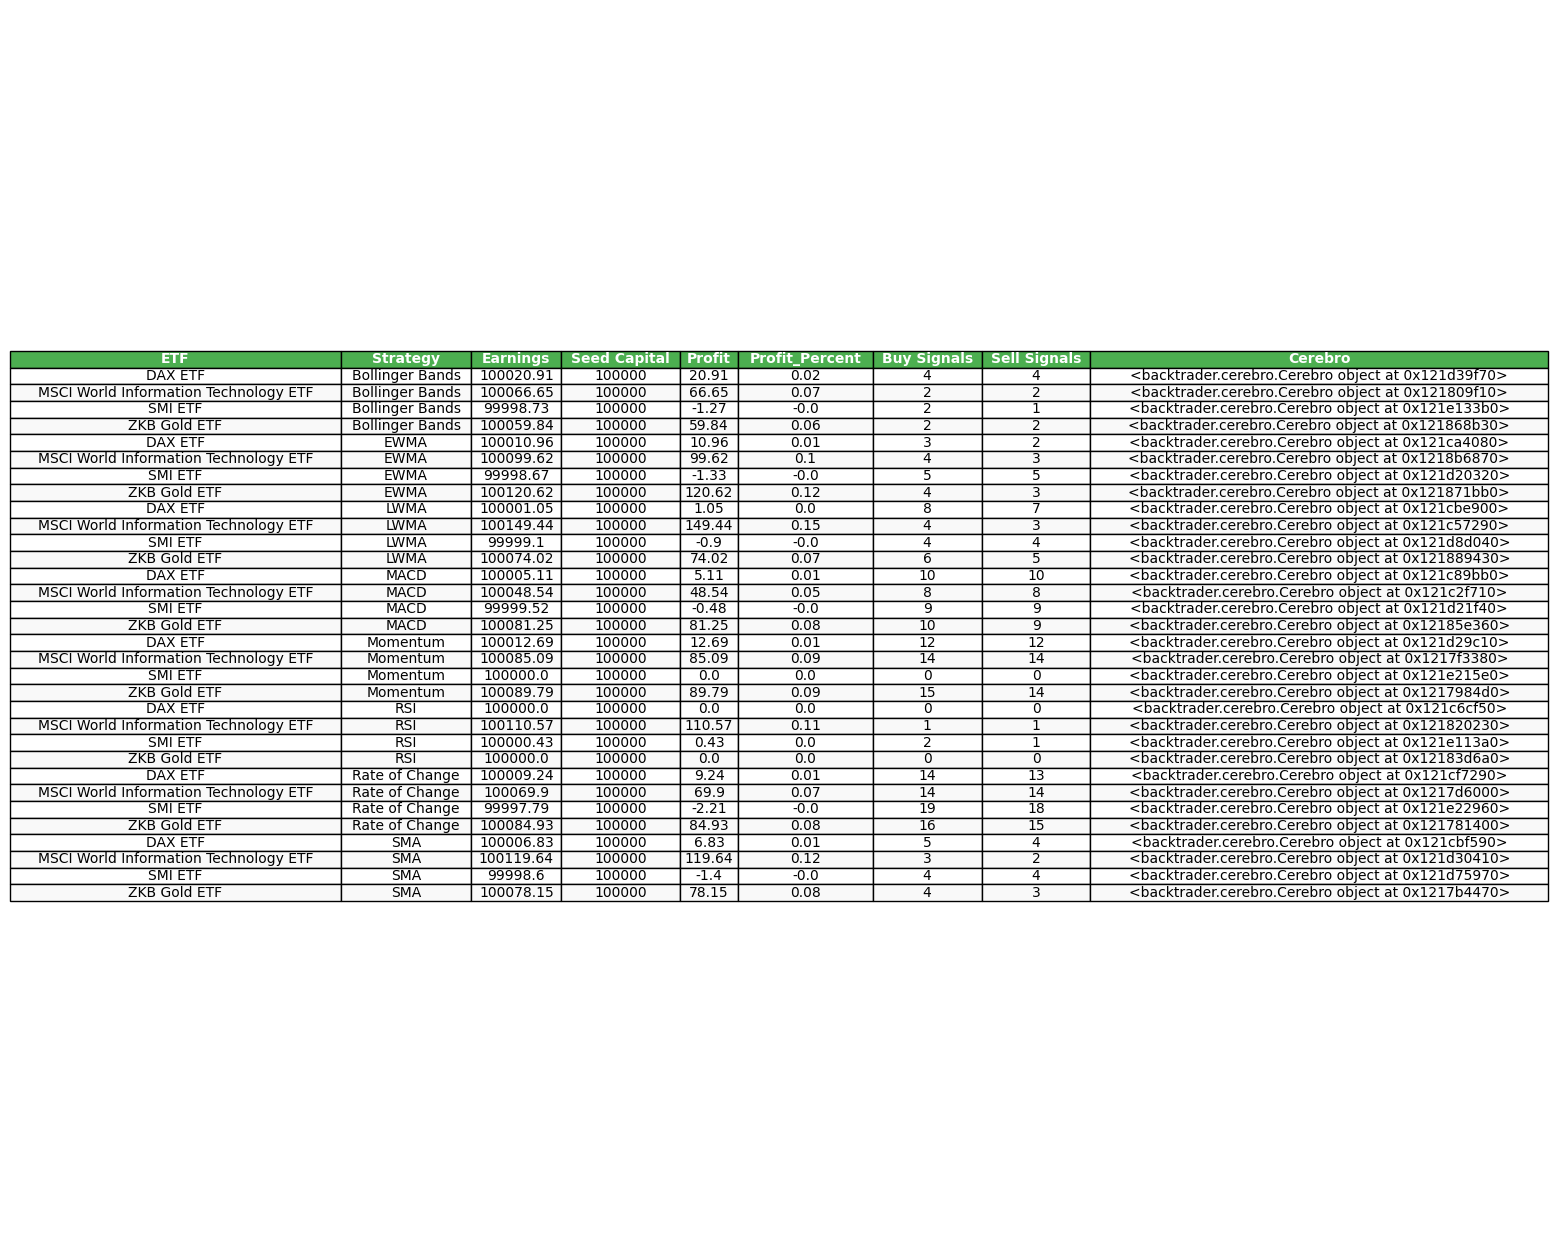

In [63]:
# Tabelle darstellen
display_table_with_matplotlib(earnings_df)